In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
from statannot import add_stat_annotation
import warnings
warnings.filterwarnings('ignore')

# Read microbiome data and metadata

In [6]:
# quantitative data
df_facs = pd.read_excel('supp/41586_2017_BFnature24460_MOESM2_ESM.xlsx',sheet_name='Supplementary Table S5')
df_facs = df_facs[['Individual','Health status','Average cell count (per gram of fresh feces)','Average cell count (per gram of frozen feces)']]
df_facs.columns = ['SubjectID','Group','FACS_fresh','FACS_frozen']

# metadata
df_meta = pd.read_csv('qiime2_output/SraRunTable.txt')
df_meta = df_meta[['Run','sample_name']]
df_meta.columns = ['Run','SubjectID']
df_meta = pd.merge(df_meta, df_facs, left_on='SubjectID', right_on='SubjectID', how='inner').set_index('Run')

# taxonomy
df_tax = pd.read_csv('qiime2_output/taxonomy.tsv', sep="\t").rename({'Feature ID':'ASV'}, axis=1)
df_tax = df_tax[df_tax.Taxon.str.contains('d__Bacteria')]
df_tax = df_tax[~(df_tax.Taxon.str.contains('Chloroplast') | df_tax.Taxon.str.contains('Mitochondria'))]
df_tax['LowestTaxonomy'] = [t.split(';')[-1].strip() for t in df_tax.Taxon]

# count
df_count = pd.read_csv('qiime2_output/feature-table/feature-table.from_biom.txt', sep="\t", index_col=0, skiprows=[0])
df_count = df_count.loc[df_tax['ASV']].T
sample_ids_w_suff_reads = list(df_count.sum(axis=1)[df_count.sum(axis=1)>=1000].index)
df_count = df_count.loc[set(df_meta.index).intersection(set(sample_ids_w_suff_reads))]
df_count = df_count.loc[:, (df_count != 0).any(axis=0)]
df_relabun = df_count.div(df_count.sum(axis=1), axis=0)

# oral fraction
df_blast_HMPv35oral = pd.read_csv("qiime2_output/asv-sequences/blast_HMPv35oral/blast_HMPv35oral_p100.txt", sep="\t", comment="#", header=None)
df_blast_HMPv35oral.columns = ['query_accver', 'subject_accver', 'perc_identity', 'alignment_length', 'mismatches', 'gap_opens', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
df_oral = df_relabun[set(df_relabun.columns).intersection(set(df_blast_HMPv35oral.query_accver))].sum(axis=1).to_frame().rename({0:'OralFrac'}, axis=1)

df_meta_oral = pd.merge(df_meta, df_oral, left_index=True, right_index=True, how='inner')
df_meta_oral['log10_OralFrac'] = np.log10(df_meta_oral['OralFrac'])
df_meta_oral['log10_FACS_fresh'] = np.log10(df_meta_oral['FACS_fresh'])
df_meta_oral['log10_FACS_frozen'] = np.log10(df_meta_oral['FACS_frozen'])

# Fig. 5a

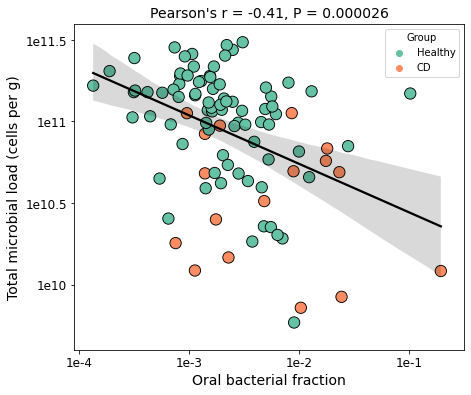

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))

df2_meta_oral = df_meta_oral[df_meta_oral.OralFrac>0]
_ = sns.scatterplot(x="log10_OralFrac", y="log10_FACS_frozen", data=df2_meta_oral, hue='Group', palette='Set2', s=128, ax=ax, edgecolor='k')
_ = sns.regplot(x="log10_OralFrac", y="log10_FACS_frozen", data=df2_meta_oral, scatter=False, color='k', ax=ax)
slope, intercept, r_value, p_value, std_err = stats.linregress(df2_meta_oral['log10_OralFrac'], df2_meta_oral['log10_FACS_frozen'])
_ = ax.set_title('Pearson\'s r = %2.2f, P = %2.6f'%(r_value, p_value), fontsize=14)
_ = ax.set_xlim([-4.05, -0.5])
_ = ax.set_ylim([9.6, 11.6])
_ = ax.set_xticks([-4,-3,-2,-1])
_ = ax.set_xticklabels(['1e-4','1e-3','1e-2','1e-1'], fontsize=12)
_ = ax.set_xlabel('Oral bacterial fraction', fontsize=14)
_ = ax.set_yticks([10,10.5,11,11.5])
_ = ax.set_yticklabels(['1e10','1e10.5','1e11','1e11.5'], fontsize=12)
_ = ax.set_ylabel('Total microbial load (cells per g)', fontsize=14)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Healthy v.s. CD: Welch's t-test independent samples, P_val=2.011e-02 stat=-2.528e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Healthy v.s. CD: Welch's t-test independent samples, P_val=1.204e-04 stat=4.711e+00


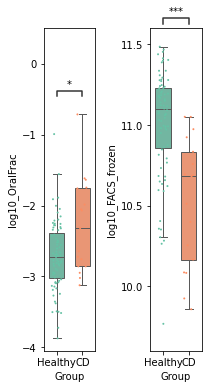

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(3,5.5))

df2_meta_oral = df_meta_oral[df_meta_oral.OralFrac>0]

# oral cavity
_ = sns.boxplot(y="log10_OralFrac", x="Group", data=df2_meta_oral, width=.6, ax=ax[0], order=['Healthy','CD'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="log10_OralFrac", x="Group", data=df2_meta_oral, size=2, color=".3", linewidth=0, ax=ax[0], jitter=0.2, palette='Set2', dodge=True, order=['Healthy','CD'])
_ = add_stat_annotation(ax[0], data=df2_meta_oral, y="log10_OralFrac", x="Group", order=['Healthy','CD'],
                        comparisons_correction=None,
                        box_pairs=[("Healthy","CD")],
                        test='t-test_welch', text_format='star', loc='outside', verbose=1)
_ = ax[0].set_ylim([-4.05,0.5])
_ = ax[0].set_yticks([-4,-3,-2,-1,0])

# microbial load
_ = sns.boxplot(y="log10_FACS_frozen", x="Group", data=df2_meta_oral, width=.6, ax=ax[1], order=['Healthy','CD'], palette='Set2', linewidth=1, showfliers=False)
_ = sns.stripplot(y="log10_FACS_frozen", x="Group", data=df2_meta_oral, size=2, color=".3", linewidth=0, ax=ax[1], jitter=0.2, palette='Set2', dodge=True, order=['Healthy','CD'])
_ = add_stat_annotation(ax[1], data=df2_meta_oral, y="log10_FACS_frozen", x="Group", order=['Healthy','CD'],
                        comparisons_correction=None,
                        box_pairs=[("Healthy","CD")],
                        test='t-test_welch', text_format='star', loc='outside', verbose=1)
_ = ax[1].set_ylim([9.6,11.6])
_ = ax[1].set_yticks([10,10.5,11,11.5])

plt.tight_layout()